## Uso de Decision Trees para mostrar explicação de decisões via regras derivadas dos ramos da DT.

[Text(0.4, 0.8333333333333334, 'petal width (cm) <= 0.8\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.6, 0.5, 'petal width (cm) <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

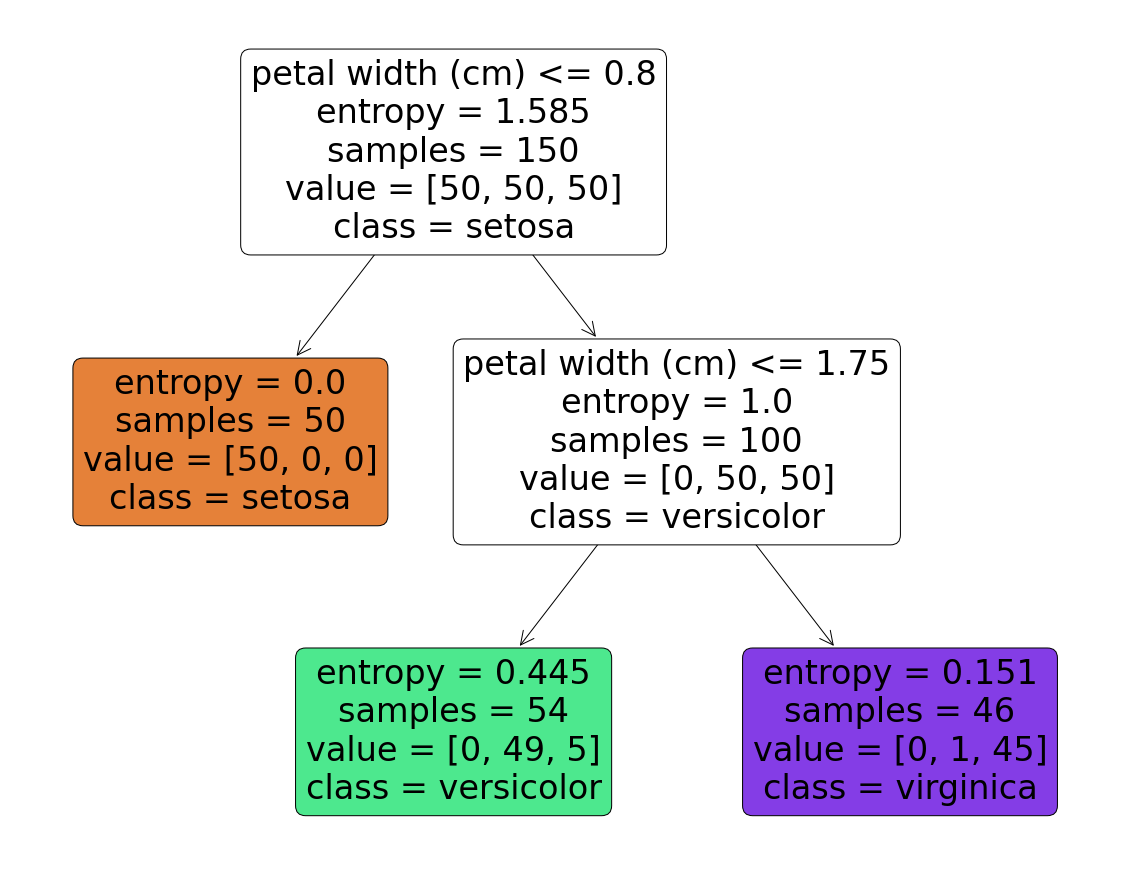

In [7]:
from sklearn.datasets import load_iris
from sklearn import tree
import matplotlib.pyplot as plt
iris = load_iris()
X, y = iris.data, iris.target

feature_names, class_names = iris['feature_names'], iris['target_names']
clf = tree.DecisionTreeClassifier(criterion='entropy',ccp_alpha=0.1)
plt.figure(figsize=(20,16))
clf = clf.fit(X, y)
tree.plot_tree(clf,feature_names=iris.feature_names,class_names=iris.target_names,filled=True, rounded=True)

[Text(0.5, 0.8333333333333334, 'CPU <= 0.016\nentropy = 2.0\nsamples = 1441\nvalue = [361, 360, 360, 360]\nclass = busort'),
 Text(0.25, 0.5, 'CPU <= 0.013\nentropy = 1.014\nsamples = 720\nvalue = [361, 0, 358, 1]\nclass = busort'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.072\nsamples = 346\nvalue = [343, 0, 3, 0]\nclass = busort'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.305\nsamples = 374\nvalue = [18, 0, 355, 1]\nclass = busort_II2'),
 Text(0.75, 0.5, 'time <= 3.498\nentropy = 1.025\nsamples = 721\nvalue = [0, 360, 2, 359]\nclass = busort_func'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.399\nsamples = 312\nvalue = [0, 290, 2, 20]\nclass = busort_func'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.66\nsamples = 409\nvalue = [0, 70, 0, 339]\nclass = busort_II')]

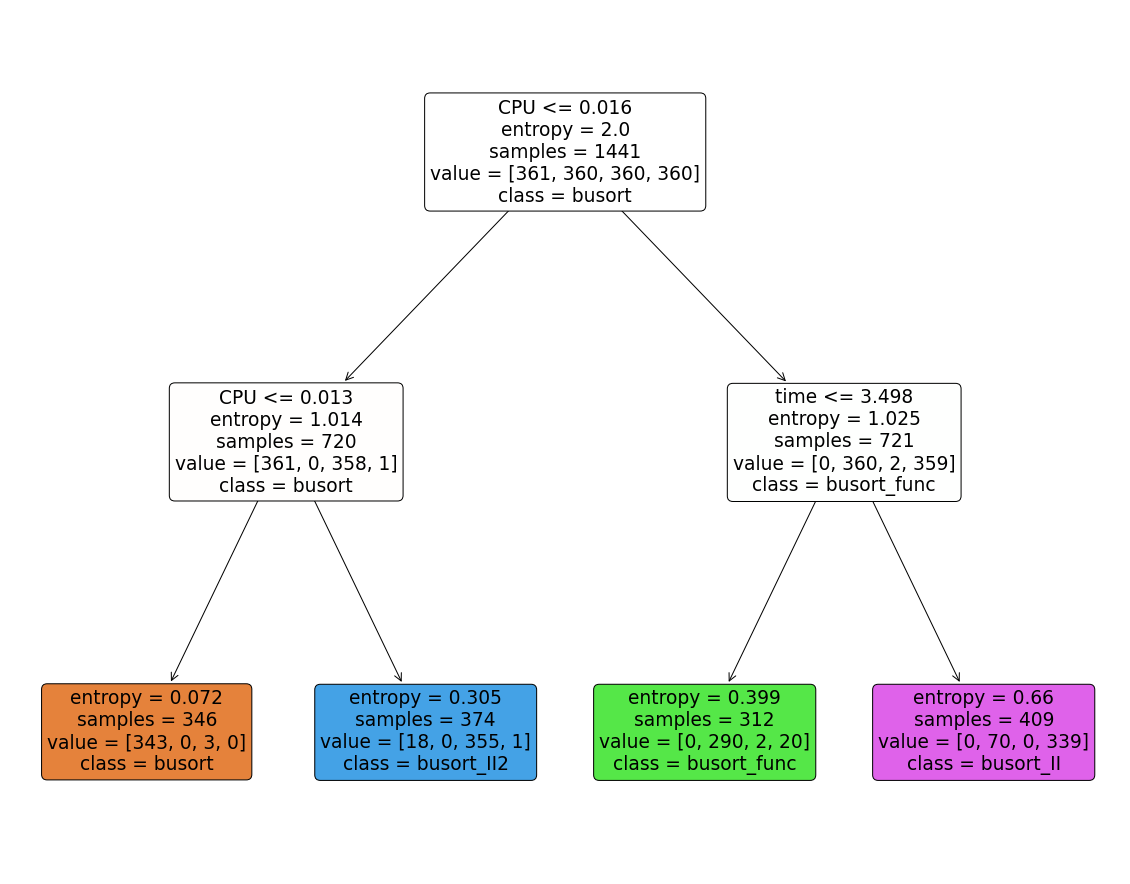

In [8]:
# usando o nosso dataset cv.csv
import pandas as pd
file_name = 'sample_data/C2.csv'
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".", names=['test','PKG','CPU','time'])

y = df.test
X = df.drop(columns=['test'])

classes = ['busort','busort_func','busort_II2','busort_II']
atribs = ['PKG','CPU','time']

clf = tree.DecisionTreeClassifier(criterion='entropy',ccp_alpha=0.1)
plt.figure(figsize=(20,16))
clf = clf.fit(X, y)
tree.plot_tree(clf,feature_names=atribs,class_names=classes,filled=True, rounded=True)


In [9]:
# Modulo MDLP
#(no colab não consegui instalar o modulo e importar. Assim
# inclui diretamento o código)


import pandas as pd
import numpy as np
from math import log

def entropy_numpy(data_classes, base=2):
    '''
    Computes the entropy of a set of labels (class instantiations)
    :param base: logarithm base for computation
    :param data_classes: Series with labels of examples in a dataset
    :return: value of entropy
    '''
    classes = np.unique(data_classes)
    N = len(data_classes)
    ent = 0  # initialize entropy

    # iterate over classes
    for c in classes:
        partition = data_classes[data_classes == c]  # data with class = c
        proportion = len(partition) / N
        #update entropy
        ent -= proportion * log(proportion, base)

    return ent

def cut_point_information_gain_numpy(X, y, cut_point):
    '''
    Return de information gain obtained by splitting a numeric attribute in two according to cut_point
    :param dataset: pandas dataframe with a column for attribute values and a column for class
    :param cut_point: threshold at which to partition the numeric attribute
    :param feature_label: column label of the numeric attribute values in data
    :param class_label: column label of the array of instance classes
    :return: information gain of partition obtained by threshold cut_point
    '''
    entropy_full = entropy_numpy(y)  # compute entropy of full dataset (w/o split)

    #split data at cut_point
    data_left_mask = X <= cut_point #dataset[dataset[feature_label] <= cut_point]
    data_right_mask = X > cut_point #dataset[dataset[feature_label] > cut_point]
    (N, N_left, N_right) = (len(X), data_left_mask.sum(), data_right_mask.sum())

    gain = entropy_full - (N_left / N) * entropy_numpy(y[data_left_mask]) - \
        (N_right / N) * entropy_numpy(y[data_right_mask])

    return gain




import numpy as np
#from Entropy import entropy_numpy, cut_point_information_gain_numpy
from math import log
from sklearn.base import TransformerMixin
from sklearn import datasets
from sklearn.model_selection import train_test_split

def previous_item(a, val):
    idx = np.where(a == val)[0][0] - 1
    return a[idx]

class MDLP_Discretizer(TransformerMixin):
    def __init__(self, features=None, raw_data_shape=None):
        '''
        initializes discretizer object:
            saves raw copy of data and creates self._data with only features to discretize and class
            computes initial entropy (before any splitting)
            self._features = features to be discretized
            self._classes = unique classes in raw_data
            self._class_name = label of class in pandas dataframe
            self._data = partition of data with only features of interest and class
            self._cuts = dictionary with cut points for each feature
        :param X: pandas dataframe with data to discretize
        :param class_label: name of the column containing class in input dataframe
        :param features: if !None, features that the user wants to discretize specifically
        :return:
        '''
        #Initialize descriptions of discretizatino bins
        self._bin_descriptions = {}

        #Create array with attr indices to discretize
        if features is None:  # Assume all columns are numeric and need to be discretized
            if raw_data_shape is None:
                raise Exception("If feautes=None, raw_data_shape must be a non-empty tuple")
            self._col_idx = range(raw_data_shape[1])
        else:
            if not isinstance(features, np.ndarray):
                features = np.array(features)
            if np.issubdtype(features.dtype, np.integer):
                self._col_idx = features
            elif np.issubdtype(features.dtype, np.bool):  # features passed as mask
                if raw_data_shape is None:
                    raise Exception('If features is a boolean array, raw_data_shape must be != None')
                if len(features) != self._data_raw.shape[1]:
                    raise Exception('Column boolean mask must be of dimensions (NColumns,)')
                self._col_idx = np.where(features)
            else:
                raise Exception('features argument must a np.array of column indices or a boolean mask')

    def fit(self, X, y):
        self._data_raw = X  # copy of original input data
        self._class_labels = y.reshape(-1, 1)  # make sure class labels is a column vector
        self._classes = np.unique(self._class_labels)


        if len(self._col_idx) != self._data_raw.shape[1]:  # some columns will not be discretized
            self._ignore_col_idx = np.array([var for var in range(self._data_raw.shape[1]) if var not in self._col_idx])

        # initialize feature bins cut points
        self._cuts = {f: [] for f in self._col_idx}

        # pre-compute all boundary points in dataset
        self._boundaries = self.compute_boundary_points_all_features()

        # get cuts for all features
        self.all_features_accepted_cutpoints()

        #generate bin string descriptions
        self.generate_bin_descriptions()

        #Generate one-hot encoding schema

        return self

    def transform(self, X, inplace=False):
        if inplace:
            discretized = X
        else:
            discretized = X.copy()
        discretized = self.apply_cutpoints(discretized)
        return discretized
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X, inplace=True)

    def MDLPC_criterion(self, X, y, feature_idx, cut_point):
        '''
        Determines whether a partition is accepted according to the MDLPC criterion
        :param feature: feature of interest
        :param cut_point: proposed cut_point
        :param partition_index: index of the sample (dataframe partition) in the interval of interest
        :return: True/False, whether to accept the partition
        '''
        #get dataframe only with desired attribute and class columns, and split by cut_point
        left_mask = X <= cut_point
        right_mask = X > cut_point

        #compute information gain obtained when splitting data at cut_point
        cut_point_gain = cut_point_information_gain_numpy(X, y, cut_point)
        #compute delta term in MDLPC criterion
        N = len(X) # number of examples in current partition
        partition_entropy = entropy_numpy(y)
        k = len(np.unique(y))
        k_left = len(np.unique(y[left_mask]))
        k_right = len(np.unique(y[right_mask]))
        entropy_left = entropy_numpy(y[left_mask])  # entropy of partition
        entropy_right = entropy_numpy(y[right_mask])
        delta = log(3 ** k, 2) - (k * partition_entropy) + (k_left * entropy_left) + (k_right * entropy_right)

        #to split or not to split
        gain_threshold = (log(N - 1, 2) + delta) / N

        if cut_point_gain > gain_threshold:
            return True
        else:
            return False

    def feature_boundary_points(self, values):
        '''
        Given an attribute, find all potential cut_points (boundary points)
        :param feature: feature of interest
        :param partition_index: indices of rows for which feature value falls whithin interval of interest
        :return: array with potential cut_points
        '''

        missing_mask = np.isnan(values)
        data_partition = np.concatenate([values[:, np.newaxis], self._class_labels], axis=1)
        data_partition = data_partition[~missing_mask]
        #sort data by values
        data_partition = data_partition[data_partition[:, 0].argsort()]

        #Get unique values in column
        unique_vals = np.unique(data_partition[:, 0])  # each of this could be a bin boundary
        #Find if when feature changes there are different class values
        boundaries = []
        for i in range(1, unique_vals.size):  # By definition first unique value cannot be a boundary
            previous_val_idx = np.where(data_partition[:, 0] == unique_vals[i-1])[0]
            current_val_idx = np.where(data_partition[:, 0] == unique_vals[i])[0]
            merged_classes = np.union1d(data_partition[previous_val_idx, 1], data_partition[current_val_idx, 1])
            if merged_classes.size > 1:
                boundaries += [unique_vals[i]]
        boundaries_offset = np.array([previous_item(unique_vals, var) for var in boundaries])
        return (np.array(boundaries) + boundaries_offset) / 2

    def compute_boundary_points_all_features(self):
        '''
        Computes all possible boundary points for each attribute in self._features (features to discretize)
        :return:
        '''
        def padded_cutpoints_array(arr, N):
            cutpoints = self.feature_boundary_points(arr)
            padding = np.array([np.nan] * (N - len(cutpoints)))
            return np.concatenate([cutpoints, padding])

        boundaries = np.empty(self._data_raw.shape)
        boundaries[:, self._col_idx] = np.apply_along_axis(padded_cutpoints_array, 0, self._data_raw[:, self._col_idx], self._data_raw.shape[0])
        mask = np.all(np.isnan(boundaries), axis=1)
        return boundaries[~mask]

    def boundaries_in_partition(self, X, feature_idx):
        '''
        From the collection of all cut points for all features, find cut points that fall within a feature-partition's
        attribute-values' range
        :param data: data partition (pandas dataframe)
        :param feature: attribute of interest
        :return: points within feature's range
        '''
        range_min, range_max = (X.min(), X.max())
        mask = np.logical_and((self._boundaries[:, feature_idx] > range_min), (self._boundaries[:, feature_idx] < range_max))
        return np.unique(self._boundaries[:, feature_idx][mask])

    def best_cut_point(self, X, y, feature_idx):
        '''
        Selects the best cut point for a feature in a data partition based on information gain
        :param data: data partition (pandas dataframe)
        :param feature: target attribute
        :return: value of cut point with highest information gain (if many, picks first). None if no candidates
        '''
        candidates = self.boundaries_in_partition(X, feature_idx=feature_idx)
        if candidates.size == 0:
            return None
        gains = [(cut, cut_point_information_gain_numpy(X, y, cut_point=cut)) for cut in candidates]
        gains = sorted(gains, key=lambda x: x[1], reverse=True)

        return gains[0][0] #return cut point

    def single_feature_accepted_cutpoints(self, X, y, feature_idx):
        '''
        Computes the cuts for binning a feature according to the MDLP criterion
        :param feature: attribute of interest
        :param partition_index: index of examples in data partition for which cuts are required
        :return: list of cuts for binning feature in partition covered by partition_index
        '''

        #Delte missing data
        mask = np.isnan(X)
        X = X[~mask]
        y = y[~mask]

        #stop if constant or null feature values
        if len(np.unique(X)) < 2:
            return
        #determine whether to cut and where
        cut_candidate = self.best_cut_point(X, y, feature_idx)
        if cut_candidate == None:
            return
        decision = self.MDLPC_criterion(X, y, feature_idx, cut_candidate)

        # partition masks
        left_mask = X <= cut_candidate
        right_mask = X > cut_candidate

        #apply decision
        if not decision:
            return  # if partition wasn't accepted, there's nothing else to do
        if decision:
            #now we have two new partitions that need to be examined
            left_partition = X[left_mask]
            right_partition = X[right_mask]
            if (left_partition.size == 0) or (right_partition.size == 0):
                return #extreme point selected, don't partition
            self._cuts[feature_idx] += [cut_candidate]  # accept partition
            self.single_feature_accepted_cutpoints(left_partition, y[left_mask], feature_idx)
            self.single_feature_accepted_cutpoints(right_partition, y[right_mask], feature_idx)
            #order cutpoints in ascending order
            self._cuts[feature_idx] = sorted(self._cuts[feature_idx])
            return

    def all_features_accepted_cutpoints(self):
        '''
        Computes cut points for all numeric features (the ones in self._features)
        :return:
        '''
        for attr in self._col_idx:
            self.single_feature_accepted_cutpoints(X=self._data_raw[:, attr], y=self._class_labels, feature_idx=attr)
        return

    def generate_bin_descriptions(self):
        '''
        Discretizes data by applying bins according to self._cuts. Saves a new, discretized file, and a description of
        the bins
        :param out_data_path: path to save discretized data
        :param out_bins_path: path to save bins description
        :return:
        '''
        bin_label_collection = {}
        for attr in self._col_idx:
            if len(self._cuts[attr]) == 0:
                bin_label_collection[attr] = ['All']
            else:
                cuts = [-np.inf] + self._cuts[attr] + [np.inf]
                start_bin_indices = range(0, len(cuts) - 1)
                bin_labels = ['%s_to_%s' % (str(cuts[i]), str(cuts[i+1])) for i in start_bin_indices]
                bin_label_collection[attr] = bin_labels
                self._bin_descriptions[attr] = {i: bin_labels[i] for i in range(len(bin_labels))}


    def apply_cutpoints(self, data):
        '''
        Discretizes data by applying bins according to self._cuts. Saves a new, discretized file, and a description of
        the bins
        :param out_data_path: path to save discretized data
        :param out_bins_path: path to save bins description
        :return:
        '''
        for attr in self._col_idx:
            if len(self._cuts[attr]) == 0:
                # data[:, attr] = 'All'
                data[:, attr] = 0
            else:
                cuts = [-np.inf] + self._cuts[attr] + [np.inf]
                discretized_col = np.digitize(x=data[:, attr], bins=cuts, right=False).astype('float') - 1
                discretized_col[np.isnan(data[:, attr])] = np.nan
                data[:, attr] = discretized_col
        return data



In [10]:
# Fayyad Irani Discretization
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
#from MDLP import MDLP_Discretizer



def main1():

    ######### USE-CASE EXAMPLE #############
    from sklearn.datasets import load_iris
    import numpy as np

    #read dataset
    dataset = load_iris()
    X, y = dataset['data'], dataset['target']
    feature_names, class_names = dataset['feature_names'], dataset['target_names']
    numeric_features = np.arange(X.shape[1])  # all features in this dataset are numeric. These will be discretized
    
    #Split between training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    #Initialize discretizer object and fit to training data
    discretizer = MDLP_Discretizer(features=numeric_features)
    discretizer.fit(X_train, y_train)
    X_train_discretized = discretizer.transform(X_train)

    #apply same discretization to test set
    X_test_discretized = discretizer.transform(X_test)

    #Print a slice of original and discretized data
    print("Original dataset:\n" + str(X_train[0:5]))
    print("Discretized dataset:\n" + str(X_train_discretized[0:5]))
    print(numeric_features)
    print(class_names)

    #see how feature 0 was discretized
    for x in range(len(feature_names)):
        print("Feature: " + feature_names[x])
        print("Interval cut-points: " + str(discretizer._cuts[x]))
        print("Bin descriptions: " + str(discretizer._bin_descriptions[x]))


    # transforma os codigos do discretizado em intervalos
    #cria novo dataset vazio
    novo = []
    for i in range(len(X_train_discretized)):
      aux = [0] * len(X_train_discretized[i])
      novo += [aux]

    # transforma de acordo com os intervalos
    for i in range(len(novo)):
      for j in range(len(novo[i])):
        novo[i][j] = discretizer._bin_descriptions[j][int(X_train_discretized[i][j])]
        

    # imprime os primeiros 10
    print(feature_names)
    for i in range(10):
      for c in novo[i]:
        print(str(c)+"         ",end="")
      print()
    

    """ Tentar um modelo tipo ID3 de arvores de classificacao 
        Usa fayyad Irani para discretizar e ver o aspeto da arvore gerada
    

    from sklearn import tree
    clf = tree.DecisionTreeClassifier(criterion='entropy')#,ccp_alpha=0.01)
    clf = clf.fit(novo, y_train)
    print()
    print("Test evalution - probs Class Distrib")
    print(class_names)
    print(clf.predict_proba(X_test_discretized))
    plt.figure(figsize=(20,16))
    feature_names, class_names = iris['feature_names'], iris['target_names']
    tree.plot_tree(clf,feature_names=iris.feature_names,class_names=iris.target_names,filled=True, rounded=True)
    """


def nosso():

    
    import numpy as np

    #read dataset
    file_name = 'sample_data/C2.csv'
    df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".", names=['test','PKG','CPU','time'])

    y = df.test.values
    X = df.drop(columns=['test']).values
    

    classes = ['busort','busort_func','busort_II2','busort_II']
    atribs = ['PKG','CPU','time']

    # all features in this dataset are numeric. These will be discretized
    numeric_features = np.arange(X.shape[1])


    #Initialize discretizer object and fit to training data
    discretizer = MDLP_Discretizer(features=numeric_features)
    discretizer.fit(X, y)
    X_discretized = discretizer.transform(X)


    #Print a slice of original and discretized data
    print("Original dataset:\n" + str(X[0:5]))
    print("Discretized dataset:\n" + str(X_discretized[0:5]))
    print(numeric_features)
    print(classes)

    #see how feature 0 was discretized
    for x in range(len(atribs)):
        print("Feature: " + feature_names[x])
        print("Interval cut-points: " + str(discretizer._cuts[x]))
        print("Bin descriptions: " + str(discretizer._bin_descriptions[x]))


    # transforma os codigos do discretizado em intervalos
    #cria novo dataset vazio
    novo = []
    for i in range(len(X_discretized)):
      aux = [0] * len(X_discretized[i])
      novo += [aux]

    # transforma de acordo com os intervalos
    for i in range(len(novo)):
      for j in range(len(novo[i])):
        novo[i][j] = discretizer._bin_descriptions[j][int(X_discretized[i][j])]
        

    # imprime os primeiros 10
    print(feature_names)
    for i in range(10):
      for c in novo[i]:
        print(str(c)+"         ",end="")
      print()

#main1()
nosso()


Original dataset:
[[0.01098633 0.00915527 3.165     ]
 [0.01318359 0.01092529 3.069     ]
 [0.01519775 0.00939941 2.617     ]
 [0.01055908 0.00958252 2.572     ]
 [0.00994873 0.00994873 2.671     ]]
Discretized dataset:
[[0. 0. 3.]
 [1. 0. 3.]
 [2. 0. 3.]
 [0. 0. 3.]
 [0. 0. 3.]]
[0 1 2]
['busort', 'busort_func', 'busort_II2', 'busort_II']
Feature: sepal length (cm)
Interval cut-points: [0.012207031, 0.014739990500000001, 0.016052246, 0.0171203615, 0.018951416, 0.022155762000000002, 0.024078369500000002]
Bin descriptions: {0: '-inf_to_0.012207031', 1: '0.012207031_to_0.014739990500000001', 2: '0.014739990500000001_to_0.016052246', 3: '0.016052246_to_0.0171203615', 4: '0.0171203615_to_0.018951416', 5: '0.018951416_to_0.022155762000000002', 6: '0.022155762000000002_to_0.024078369500000002', 7: '0.024078369500000002_to_inf'}
Feature: sepal width (cm)
Interval cut-points: [0.0124206545, 0.012664795, 0.013519287500000001, 0.0157165525, 0.0178527835]
Bin descriptions: {0: '-inf_to_0.01242065

In [12]:
"""import os, sys 
#to be able to interact with Google Drive's operating system
from google.colab import drive 
#drive is a module that allows us use Python to interact with google drive
drive.mount('/content/gdrive') 
#mounting google drive allows us to work with its contents
nb_path = '/content/notebooks'
os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)
#The last three lines are what changes the path of the file.
# %%
"""
# %%
# Import the necessary modules and libraries
"""
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
"""

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import DecisionTreeRegressor, export_text
from m5py import M5Prime

# %%
# dataset
file_name = 'sample_data/C2.csv'
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".", names=['test','PKG','CPU','time'])

# faz preprocessamento de categoricos para booleanos (categ com 4 valores --> 4 atribs bool)
df = pd.get_dummies(df, columns=["test"])

#X = df[['PKG','time']]
X1 = df.CPU
X2 = df.PKG
X3 = df.test_bubblesort
X4 = df.test_bubblesort_func
X5 = df.test_bubblesort_ll
X6 = df.test_bubblesort_ll2

X = np.c_[X1,X2,X3,X4,X5,X6]
y = df.time

feature_names=['PKG','CPU','bsort','bsort_func','bsort_ll','bsort_ll2']


# %%
# Define regression models and evaluate them on 10-fold CV
regr_0 = DecisionTreeRegressor(ccp_alpha=0.1)
regr_0_label = "Tree 0"
#regr_0_scores = cross_validate(regr_0, X, y, cv=3,scoring='r2')

regr_1 = M5Prime(use_smoothing=True, use_pruning=True,ccp_alpha=0.001)
regr_1_label = "Tree 1"
#regr_1_scores = cross_validate(regr_1, X, y, cv=3,scoring='r2')

#scores = np.c_[regr_0_scores,regr_1_scores]
#avgs = scores.mean(axis=0)
#stds = scores.std(axis=0)
#labels = [regr_0_label,regr_1_label]

#scores_df = pd.DataFrame(data=scores, columns=labels)
#sns.violinplot(data=scores_df)

# %%
# Fit the final models and print the trees:
#
regr_0.fit(X, y)
print("\n----- %s" % regr_0_label)
print(export_text(regr_0, feature_names=feature_names))

# %%
regr_1.fit(X, y)
print("\n----- %s" % regr_1_label)
#print(export_text(regr_1,feature_names=feature_names))
print(regr_1.as_pretty_text(feature_names=feature_names))









Mounted at /content/gdrive

----- Tree 0
|--- PKG <= 0.02
|   |--- value: [2.49]
|--- PKG >  0.02
|   |--- value: [3.53]


----- Tree 1
M5Prime (pre-smoothed with constant 15):

PKG <= 0.016 [friedman_mse=0.326, samples=1441] (err=0.142, params=27)
|   PKG <= 0.009 [friedman_mse=0.094, samples=720] (err=0.166, params=24)
|   |   LEAF [friedman_mse=0.037, samples=34] : LM1 (err=0.25, params=4)
|   |   PKG <= 0.01 [friedman_mse=0.056, samples=686] (err=0.161, params=19)
|   |   |   LEAF [friedman_mse=0.036, samples=173] : LM2 (err=0.189, params=4)
|   |   |   bsort <= 0.5 [friedman_mse=0.046, samples=513] (err=0.15, params=14)
|   |   |   |   LEAF [friedman_mse=0.011, samples=359] : LM3 (err=0.107, params=4)
|   |   |   |   PKG <= 0.011 [friedman_mse=0.076, samples=154] (err=0.219, params=9)
|   |   |   |   |   LEAF [friedman_mse=0.116, samples=46] : LM4 (err=0.343, params=4)
|   |   |   |   |   LEAF [friedman_mse=0.017, samples=108] : LM5 (err=0.134, params=4)
|   LEAF [friedman_mse=0.0

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [151]:
#!pip install apyori
#regras de associação
import numpy as np
from apyori import apriori


# putting output into a pandas dataframe
def inspect(output):
    lhs         = [tuple(result[2][0][0])[0] for result in output]
    rhs         = [tuple(result[2][0][1])[0] for result in output]
    support    = [result[1] for result in output]
    confidence = [result[2][0][2] for result in output]
    lift       = [result[2][0][3] for result in output]
    return list(zip(lhs, rhs, support, confidence, lift))







file_name = 'sample_data/C2.csv'
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".",names=['test','PKG','CPU','time'])

y = df.test.values
X = df.drop(columns=['test']).values
    

classes = ['busort','busort_func','busort_II2','busort_II']
atribs = ['PKG','CPU','time']

# all features in this dataset are numeric. These will be discretized
numeric_features = np.arange(X.shape[1])


#Initialize discretizer object and fit to training data
discretizer = MDLP_Discretizer(features=numeric_features)
discretizer.fit(X, y)
X_discretized = discretizer.transform(X)

# transforma os codigos do discretizado em intervalos
#cria novo dataset vazio
novo = []
for i in range(len(X_discretized)):
  aux = [0] * (len(X_discretized[i])+1)
  novo += [aux]

# transforma de acordo com os intervalos
for i in range(len(novo)):
  for j in range(len(novo[i])-1):
    novo[i][j] = atribs[j]+"="+discretizer._bin_descriptions[j][int(X_discretized[i][j])]
  novo[i][3] = "test="+y[i]
  
"""    
# imprime os primeiros 10
print(feature_names)
for i in range(10):
    print(novo[i])
"""  




#deriva modelo de regras
a_rules = apriori(novo, min_support=0.1, use_colnames = True,min_confidence=0.1, min_lift=1, min_length=2)
a_res = list(a_rules)


listRules = [list(a_res[i][0]) for i in range(0,len(a_res))]
sup = [a_res[i][1] for i in range(0,len(a_res))]
outras = [a_res[i][2] for i in range(0,len(a_res))]

print("Rules:")
for x in list(outras):
  for y in x:
    for aa in w:
        if(type(aa[0]) == 'frozenset'):
          if(len(aa[0])==0):
            print("" + " -> " + str(aa[1]) +" sup="+str(sup)+ " conf="+str(aa[2])+ " lift="+str(aa[3]))
          else:
            print(str(aa[0]) + " -> " + str(aa[1]) +" sup="+str(sup)+ " conf="+str(aa[2])+ " lift="+str(aa[3]))
    
    #print(str(a1) + " -> " + str(a2) +" sup="+str(sup)+ " conf="+str(w[1])+ " lift="+str(w[2]))
 





Rules:
